In [48]:
import pandas as pd
import geopandas as gpd
import osmnx as osm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyproj import Transformer
from shapely.geometry import *
import networkx as nx
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from cdlib import algorithms, viz

In [41]:
# import all the data
trip_data = pd.read_csv('../Data/02_Processed_Data/cleaned_trip_data.csv')
trip_data['Start date'] = pd.to_datetime(trip_data['Start date'])
trip_data['End date'] = pd.to_datetime(trip_data['End date'])
station_data = pd.read_csv('../Data/02_Processed_Data/cleaned_station_data.csv')
station_data = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data['lon'], station_data['lat'], crs='epsg:4326'))
station_data = osm.project_gdf(station_data)
central_london = osm.io.load_graphml('../Data/02_Processed_Data/Central_london.osm')

In [42]:
# add the longitude and latitude of the start and end stations
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='Start station', right_on='commonName', suffixes=('', '_start'))
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='End station', right_on='commonName', suffixes=('', '_end'))
# drop the commonName columns
trip_data.drop(columns=['commonName', 'commonName_end'], inplace=True)
# rename the lat and lon column to lat_start, lon_start
trip_data.rename(columns={'lat': 'lat_start', 'lon': 'lon_start'}, inplace=True)

In [43]:
# Get the CRS of the projected graph
crs_proj = central_london.graph['crs']

# Create a transformer to convert lat/lon to the projected CRS
transformer = Transformer.from_crs("epsg:4326", crs_proj, always_xy=True)

# Methodology

In this section we will show the methodology used to solve the problem. The methodology is divided into the following steps:

1. Clustering
2. Community Detection Algotithm


## (01) Clustering

### Clustering based on the location of the stations

In [44]:
coords = station_data[['lat', 'lon']].to_numpy()

#Determine the number of clusters (k)
num_clusters = 5  # Adjust this value based on your dataset and requirements

# Apply K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
labels = kmeans.labels_

# Add the cluster labels to the original dataframe
station_data['Cluster'] = labels

# # Plot the clusters
# plt.figure(figsize=(10, 8))
# plt.scatter(station_data['lon'], station_data['lat'], c=station_data['cluster'], cmap='viridis', marker='o')
# plt.title(f'K-Means Clustering of Bike Stations (k={num_clusters})')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.colorbar(label='Cluster Label')
# plt.show()

# Create a folium map
# Plot the stations on a map with folium
map_center = [51.509865, -0.118092]  # Center the map around central London
bike_map = folium.Map(location=map_center, zoom_start=12)

# Define a color palette for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

for i, row in station_data.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=colors[row['Cluster'] % len(colors)],
        fill=True,
        fill_color=colors[row['Cluster'] % len(colors)],
        fill_opacity=0.7,
        popup=f"Station: {row['commonName']}<br>Cluster: {row['Cluster']}"
    ).add_to(bike_map)

# Save the map to an HTML file
bike_map.save('../Data/03_Results/Clustering_Map_Location.html')

# Save the clustered station data
station_data.to_csv('../Data/03_Results/Clustered_Stations_Location.csv', index=False)
station_data.drop(columns='Cluster', inplace=True)

### Clustering based on the demand pattern

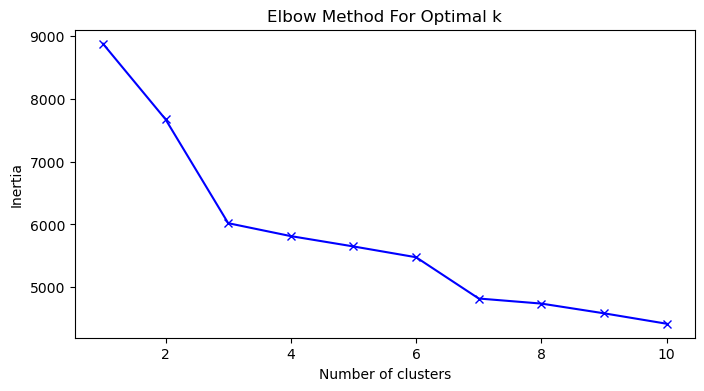

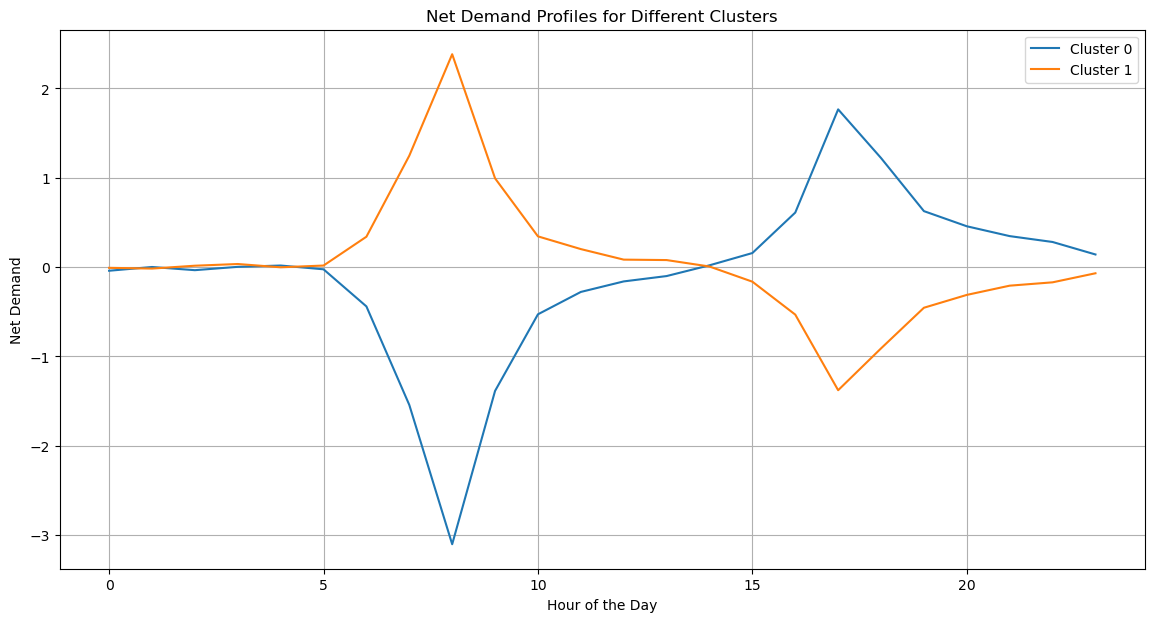

In [45]:
# Extract date and hour from the start date
trip_data['Date'] = pd.to_datetime(trip_data['Start date']).dt.date
trip_data['hour_of_the_day'] = pd.to_datetime(trip_data['Start date']).dt.hour

# Group by start station, hour, and date, then count start trips
df_start_grouped = trip_data.groupby(['Start station', 'hour_of_the_day', 'Date']).size().reset_index(name='num_start_trips')

# Calculate the average number of start trips per hour for each station
df_start_average = df_start_grouped.groupby(['Start station', 'hour_of_the_day'])['num_start_trips'].mean().reset_index(name='average_number_of_start_trips')

# Group by end station, hour, and date, then count end trips
df_end_grouped = trip_data.groupby(['End station', 'hour_of_the_day', 'Date']).size().reset_index(name='num_end_trips')

# Calculate the average number of end trips per hour for each station
df_end_average = df_end_grouped.groupby(['End station', 'hour_of_the_day'])['num_end_trips'].mean().reset_index(name='average_number_of_end_trips')

# Merge the start and end average data on station and hour
df_merged = pd.merge(df_start_average, df_end_average, left_on=['Start station', 'hour_of_the_day'], right_on=['End station', 'hour_of_the_day'], suffixes=('_start', '_end')).fillna(0)

# Calculate the net demand (start - end)
df_merged['net_demand'] = df_merged['average_number_of_start_trips'] - df_merged['average_number_of_end_trips']

# Pivot the data to have one row per station and 24 columns for each hour of the day
pivoted_data = df_merged.pivot(index='Start station', columns='hour_of_the_day', values='net_demand').fillna(0)

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(pivoted_data)

# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1, 11)  # Try 1 to 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Based on the plot, choose the optimal number of clusters
#optimal_k = int(input("Enter the optimal number of clusters based on the Elbow Method plot: "))
optimal_k = 2

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
pivoted_data['Cluster'] = kmeans.fit_predict(data_scaled)

# Reset the index to save the data properly
clustered_data = pivoted_data.reset_index()

# Save the clustered data to a new CSV file
clustered_data.to_csv('clustered_net_demand_data.csv', index=False)

# Merge the cluster data with station location data
clustered_stations = pd.merge(clustered_data, station_data, left_on='Start station', right_on='commonName')

# Plot the stations on a map with folium
map_center = [51.509865, -0.118092]  # Center the map around central London
bike_map = folium.Map(location=map_center, zoom_start=12)

# Define a color palette for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

for i, row in clustered_stations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=colors[row['Cluster'] % len(colors)],
        fill=True,
        fill_color=colors[row['Cluster'] % len(colors)],
        fill_opacity=0.7,
        popup=f"Station: {row['commonName']}<br>Cluster: {row['Cluster']}"
    ).add_to(bike_map)

# Plotting the clusters
plt.figure(figsize=(14, 7))
for cluster in range(optimal_k):
    cluster_data = pivoted_data[pivoted_data['Cluster'] == cluster].drop('Cluster', axis=1)
    cluster_mean = cluster_data.mean(axis=0)
    plt.plot(cluster_mean.index, cluster_mean.values, label=f'Cluster {cluster}')

plt.xlabel('Hour of the Day')
plt.ylabel('Net Demand')
plt.title('Net Demand Profiles for Different Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Save the map to an HTML file
bike_map.save('../Data/03_Results/Clustering_Map_Demand_Pattern.html')

# Save the clusters as an csv file
pivoted_data.to_csv('../Data/03_Results/Clustered_Stations_Demand_Pattern.csv')

## (02) Community Detection Algortihm

In [47]:
# Create the graph
G = nx.Graph()

# Add edges between stations with weights as the number of trips
for _, row in trip_data.iterrows():
    start_station = row['Start station']
    end_station = row['End station']
    if G.has_edge(start_station, end_station):
        G[start_station][end_station]['weight'] += 1
    else:
        G.add_edge(start_station, end_station, weight = 1)

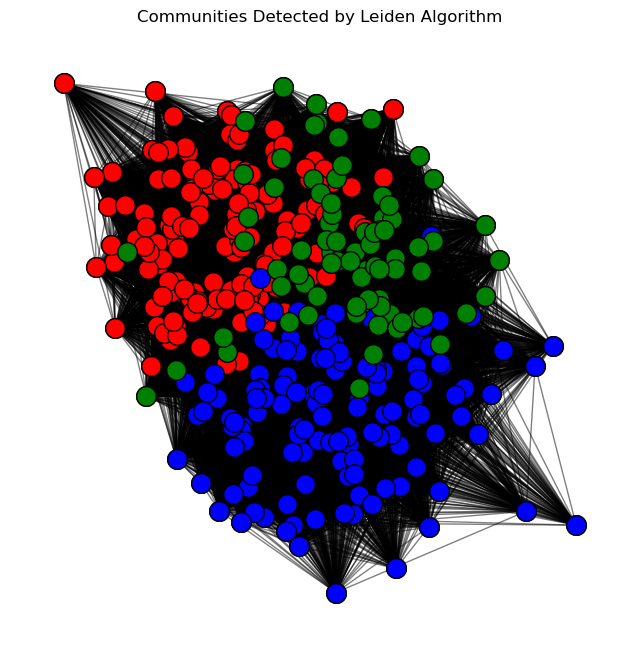

In [49]:
coms = algorithms.leiden(G)

# Visualize the communities
pos = nx.spring_layout(G)  # or you can use a different layout like pos = nx.kamada_kawai_layout(G)
viz.plot_network_clusters(G, coms, pos)

plt.title('Communities Detected by Leiden Algorithm')
plt.show()

In [50]:
# Plot the communities on a map
# Create a mapping of nodes to their communities
node_community = {}
for community_id, nodes in enumerate(coms.communities):
    for node in nodes:
        node_community[node] = community_id

# Create a DataFrame with stations and their communities
stations = list(G.nodes())
communities = [node_community[station] for station in stations]

community_df = pd.DataFrame({'Station': stations, 'Community': communities})

# Merge the cluster data with station location data
clustered_stations = pd.merge(community_df, station_data, left_on='Station', right_on='commonName')

# Plot the stations on a map with folium
map_center = [51.509865, -0.118092]  # Center the map around central London
bike_map = folium.Map(location=map_center, zoom_start=12)

# Define a color palette for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

for i, row in clustered_stations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=colors[row['Community'] % len(colors)],
        fill=True,
        fill_color=colors[row['Community'] % len(colors)],
        fill_opacity=0.7,
        popup=f"Station: {row['commonName']}<br>Community: {row['Community']}"
    ).add_to(bike_map)

# Save the map to an HTML file
bike_map.save('../Data/03_Results/Community_Detection_Alg_LEIDEN_Map.html')

# Save the DataFrame to a CSV file
community_df.to_csv('../Data/03_Results/Community_Detection_Alg_LEIDEN_Comn.csv', index=False)